# Open in Colab
<a target="_blank" href="https://colab.research.google.com/github/Nicolepcx/ai-agents-the-definitive-guide/blob/main/CH02/ch02_hierarchical_agent_teams.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# About this notebook

This notebook builds a hierarchical, team based agent system with **LangGraph** and **LangChain** that can research on the web, scrape pages, search patents, run code, and collaborate to write and persist a report to disk. It demonstrates how to compose multiple subgraphs under a top level supervisor while keeping tools, roles, and state explicit.

## What it shows

* **Two specialized teams** coordinated by supervisors

  1. **Research team** with search, scraping, Exa semantic search, and Google Patents
  2. **Document writing team** with outline creation, document read and write, editing, and a Python REPL for simple charts
* **Top level orchestrator** that routes work between the two teams and aggregates results
* **Tooling mix**: Tavily, SerpAPI, Exa, WebBaseLoader scraping, and a Python REPL
* **File persistence** in a working directory for outlines and the final report
* **Streaming runs** that print step by step updates and **Mermaid PNG** graph previews for each team and the supervisor graph

## What you will run

1. . Define research tools

   * `tavily_tool` for search results
   * `scrape_webpages` to pull and concatenate page contents
   * `patent_search` via SerpAPI Google Patents
   * `exa_search_tool` for neural search with highlight snippets
2. Define document tools

   * `create_outline`, `read_document`, `write_document`, `edit_document` that operate in a sandboxed working directory
   * `python_repl_tool` for quick calculations or charts printed to stdout
3. Build **worker nodes** using `create_react_agent` and **LLM supervisors** with structured routing that pick the next worker or finish.
4. Compile three graphs

   * `research_graph` for web research and patents
   * `paper_writing_graph` for outlining and writing with optional chart generation
   * `super_graph` that orchestrates both teams end to end
5. Execute an example

   * Ask about AI agents and patents with the research team
   * Write a poem to disk with the writing team
   * Run a full task that produces an 800 word semiconductor whitepaper, includes patent links and sources, and saves it to `semiconductor_whitepaper.txt`

## How it works

* **Supervisors**: Small LLM routers with structured output select the next worker from a fixed set or return FINISH.
* **Workers**: ReAct style agents bound to a specific tool set and prompt. Each worker returns a single concise message which is fed back to the supervisor.
* **State**: Uses `MessagesState` plus a simple `next` field. Messages flow across teams so the top level supervisor can coordinate.
* **Routing**: Implemented through `Command(goto=..., update=...)` to move between nodes while appending results to state.
* **Persistence**: File tools read and write under `WORKING_DIRECTORY`. The final task writes a complete report to disk.

## Why this pattern

* Clear separation of concerns makes behaviors predictable and testable.
* Supervisors keep control flow explicit and auditable.
* Tool use is bounded per worker which reduces prompt sprawl and improves reliability.
* The top level graph composes teams without coupling their internal details.

## Extend and adapt

* Add a citation validator between research and writing.
* Swap or add search providers.
* Replace Python REPL with a sandboxed executor.
* Persist checkpoints and traces with LangSmith for debugging and evaluation.

## Requirements and notes

* Required keys: `OPENAI_API_KEY`, `TAVILY_API_KEY`, `SERPAPI_API_KEY`, `EXA_API_KEY`.
* Web results and patent listings change over time. Outputs will vary run to run.
* File system tools write to the working directory. Use a sandbox for untrusted content or use it within a Docker setup.
* Streaming prints intermediate updates that help you trace decisions and tool calls.


# Dependencies

In [4]:
!pip install -q \
    langchain==0.3.27 \
    langgraph==0.6.7 \
    langchain-openai==0.3.33 \
    langchain_experimental==0.3.4 \
    langchain_community==0.3.30 \
    langchain-tavily==0.2.11 \
    exa_py==1.15.6 \
    python-dotenv==1.1.1


# API Key Setup

In [ ]:
# Option 1 (preferred): create a `.env` file in your project folder with:
# OPENAI_API_KEY=your_openai_key_here
# TAVILY_API_KEY=your_tavily_key_here
# SERPAPI_API_KEY=your_serpapi_key_here
# EXA_API_KEY=your_exa_key_here
#
# Option 2: set directly in the notebook with magic:
# %env OPENAI_API_KEY=your_openai_key_here
# %env TAVILY_API_KEY=your_tavily_key_here
# %env SERPAPI_API_KEY=your_serpapi_key_here
# %env EXA_API_KEY=your_exa_key_here

from dotenv import load_dotenv
import os

# Load from .env if available
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
SERPAPI_API_KEY = os.getenv("SERPAPI_API_KEY")
EXA_API_KEY = os.getenv("EXA_API_KEY")

# Fallback: ask if still missing
if not OPENAI_API_KEY:
    print("⚠️ OPENAI_API_KEY not found. You can set it with `%env` in the notebook or enter it below.")
    OPENAI_API_KEY = input("Enter your OPENAI_API_KEY: ").strip()

if not TAVILY_API_KEY:
    print("⚠️ TAVILY_API_KEY not found. You can set it with `%env` in the notebook or enter it below.")
    TAVILY_API_KEY = input("Enter your TAVILY_API_KEY: ").strip()

if not SERPAPI_API_KEY:
    print("⚠️ SERPAPI_API_KEY not found. You can set it with `%env` in the notebook or enter it below.")
    SERPAPI_API_KEY = input("Enter your SERPAPI_API_KEY: ").strip()

if not EXA_API_KEY:
    print("⚠️ EXA_API_KEY not found. You can set it with `%env` in the notebook or enter it below.")
    EXA_API_KEY = input("Enter your EXA_API_KEY: ").strip()

print("✅ API keys loaded successfully!")


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>.
    </p>
</div>

# Imports

In [ ]:
from __future__ import annotations

# Stdlib
import json
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Any, Annotated, Dict, List, Literal, Optional, Sequence
from typing_extensions import TypedDict

# Third party
from exa_py import Exa
from langchain_openai import ChatOpenAI

# LangChain
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.messages import BaseMessage, HumanMessage, trim_messages
from langchain_core.tools import tool

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import SerpAPIWrapper

from langchain_experimental.utilities import PythonREPL

from langchain_tavily import TavilySearch

# LangGraph
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command


# Create Tools

Each team will be composed of one or more agents each with one or more tools. Below, define all the tools to be used by your different teams.

We'll start with the research team.

**ResearchTeam tools**

The research team can use a search engine and url scraper to find information on the web. Feel free to add additional functionality below to boost the team performance!

**Document writing team tools**

Next up, we will give some tools for the doc writing team to use.
We define some bare-bones file-access tools below.

Note that this gives the agents access to your file-system, which can be unsafe. We also haven't optimized the tool descriptions for performance.

In [ ]:
# Define a persistent working directory
WORKING_DIRECTORY = Path("/content/working_directory")

# Ensure the working directory exists
if not WORKING_DIRECTORY.exists():
    WORKING_DIRECTORY.mkdir(parents=True)
    print(f"Created working directory: {WORKING_DIRECTORY}")
else:
    print(f"Working directory already exists: {WORKING_DIRECTORY}")


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

@tool("patent_search")
def patent_search(query: str) -> str:
    """Search with Google SERP API by a query to fine news about patents related to the query."""
    params = {
        "engine": "google_patents",
        "gl": "us",
        "hl": "en",
        }
    patent_search = SerpAPIWrapper(params=params, serpapi_api_key=serp_api_key)
    return patent_search.run(query)


@tool("exa_search_tool")
def exa_search_tool(question: str) -> str:
    """Tool using Exa's Python SDK to run semantic search and return result highlights."""
    exa = Exa(exa_api_key)

    response = exa.search_and_contents(
        question,
        type="neural",
        use_autoprompt=True,
        num_results=3,
        highlights=True
    )

    results = []
    for idx, eachResult in enumerate(response.results):
        result = {
            "Title": eachResult.title,
            "URL": eachResult.url,
            "Highlight": "".join(eachResult.highlights)
        }
        results.append(result)

    return json.dumps(results)

# Load Tavily Search Wrapper from LangChain
tavily_tool = TavilySearchResults(
    max_results= 5,
    search_depth = "advanced"
    )

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

Working directory already exists: /content/working_directory


# Helper Utilities

We are going to create a few utility functions to make it more concise when we want to:

1. Create a worker agent.
2. Create a supervisor for the sub-graph.

These will simplify the graph compositional code at the end for us so it's easier to see what's going on.

In [ ]:
class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

In [ ]:

def make_react_worker_node(
    *,
    llm: ChatOpenAI,
    name: str,
    tools: list,
    prompt: str | None = None,
    goto: str = "supervisor",
):
    agent = create_react_agent(llm, tools=tools, prompt=prompt)

    def node(state: State) -> Command[Literal["supervisor"]]:
        result: Dict[str, Any] = agent.invoke(state)
        msgs: Sequence[BaseMessage] = result.get("messages", [])
        content = getattr(msgs[-1], "content", "") if msgs else ""
        return Command(
            update={"messages": [HumanMessage(content=content, name=name)]},
            goto=goto,
        )

    return node


## Define Agent Teams

Now we can get to define our hierarchical teams. "Choose your player!"

### Research Team

The research team will have a search agent and a web scraping "research_agent" as the two worker nodes. Let's create those, as well as the team supervisor.

Now that we've created the necessary components, defining their interactions is easy. Add the nodes to the team graph, and define the edges, which determine the transition criteria.

## LLM Setup

In [ ]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [ ]:
# Prompts help to keep roles sharp
SEARCH_PROMPT = """Role: Web researcher. Use the search tool and return a
concise research note with sources. No follow-up questions."""

SCRAPER_PROMPT = """Role: Web scraper. Use the scraping tool to fetch details
from given URLs and summarize key findings. No follow-up questions."""

EXA_PROMPT = """Role: Research assistant. You can search for all recent info
on Exa Search. Your response should clearly articulate the key points you found."""

PATENT_PROMPT = """Role: Market researcher with 20 years of experience.
You are very knowledgeable in patent research and in finding up-to-date info
about patents using the Google Patents API."""

# Add workers to specs list
specs = [
    dict(
        name="search",
        tools=[tavily_tool],
        prompt=SEARCH_PROMPT,
    ),
    dict(
        name="web_scraper",
        tools=[scrape_webpages],
        prompt=SCRAPER_PROMPT,
    ),
    dict(
        name="exa_search",
        tools=[exa_search_tool],
        prompt=EXA_PROMPT,
    ),
    dict(
        name="patent_research",
        tools=[patent_search],
        prompt=PATENT_PROMPT,
    ),
]

nodes = {s["name"]: make_react_worker_node(llm=llm, **s) for s in specs}

search_node = nodes["search"]
web_scraper_node = nodes["web_scraper"]
exa_search_node = nodes["exa_search"]
patent_research_node = nodes["patent_research"]

# Supervisor that can coordinate all four
research_supervisor_node = make_supervisor_node(
    llm, ["search", "web_scraper", "exa_search", "patent_research"]
)


In [ ]:
research_builder = StateGraph(State)

# register nodes
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)
research_builder.add_node("exa_search", exa_search_node)
research_builder.add_node("patent_research", patent_research_node)

# edges
research_builder.add_edge(START, "supervisor")
research_builder.add_edge("search", "supervisor")
research_builder.add_edge("web_scraper", "supervisor")
research_builder.add_edge("exa_search", "supervisor")
research_builder.add_edge("patent_research", "supervisor")

research_graph = research_builder.compile()

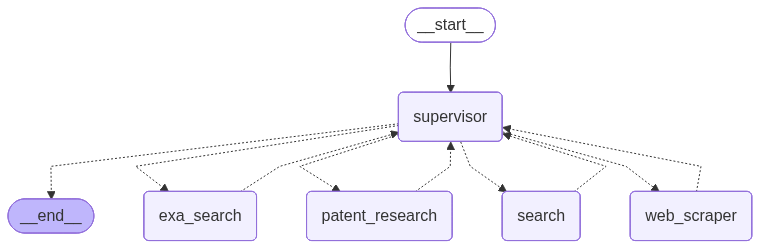

In [ ]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

We can give this team work directly. Try it out below.

In [ ]:
for s in research_graph.stream(
    {"messages": [("user", "What are AI agents? Are there any patents out there about LLM agents?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='### What are AI Agents?\n\nAI agents are software programs designed to interact with their environment, collect data, and perform tasks autonomously to achieve specific goals. They can process multimodal information such as text, voice, video, and audio, and are capable of conversing, reasoning, learning, and making decisions. AI agents are used in various applications, including robotics, gaming, and intelligent systems, where they enhance decision-making and adaptability through techniques like machine learning. They can be integrated into platforms like Google Cloud, AWS, and Microsoft 365 to perform tasks such as customer service, data analysis, and personalized user interactions [Google Cloud](https://cloud.google.com/discover/what-are-ai-agents), [IBM](https://www.ibm.com/think/topics/ai-agents), [AWS](https://aws.amazon.com/what-is/ai-agents/).\n\n### Patents on LLM Agents\n\nThere are several 

### Document Writing Team

Create the document writing team below using a similar approach. This time, we will give each agent access to different file-writing tools.

Note that we are giving file-system access to our agent here, which is not safe in all cases.

With the objects themselves created, we can form the graph.

In [ ]:
specs = [
    dict(name="doc_writer",
         tools=[write_document, edit_document, read_document],
         prompt="You can read, write and edit documents based on note-taker's outlines. Don't ask follow-up questions."),
    dict(name="note_taker",
         tools=[create_outline, read_document],
         prompt="You can read documents and create outlines for the document writer. Don't ask follow-up questions."),
    dict(name="chart_generator",
         tools=[read_document, python_repl_tool],
         prompt=None),
]

nodes = {s["name"]: make_react_worker_node(llm=llm, **s) for s in specs}
doc_writing_node = nodes["doc_writer"]
note_taking_node = nodes["note_taker"]
chart_generating_node = nodes["chart_generator"]


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)


In [ ]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

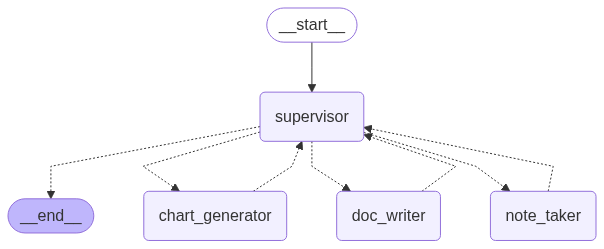

In [ ]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk as txt file.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content='The outline for the poem about cats has been saved as "poem_about_cats.txt".', additional_kwargs={}, response_metadata={}, name='note_taker', id='efe07584-0312-4cf6-b130-a0ba10e6e983')]}}
---
{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='The outline for the poem about cats has been written to the file "poem_about_cats.txt".', additional_kwargs={}, response_metadata={}, name='doc_writer', id='1c1c839e-0bd5-4faa-9ae5-d685bcaecacc')]}}
---
{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content='The outline for the poem about cats has been successfully saved to "poem_about_cats.txt".', additional_kwargs={}, response_metadata={}, name='note_taker', id='c15724da-1300-4028-be31-46fcba007a77')]}}
---
{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='The outline for the poem

## Add Layers

In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.

We'll create a _third_ graph to orchestrate the previous two, and add some connectors to define how this top-level state is shared between the different graphs.

In [ ]:
from langchain_core.messages import BaseMessage

llm = ChatOpenAI(model="gpt-4o")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [ ]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

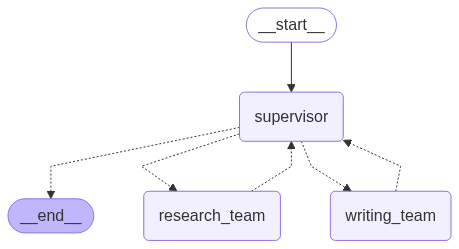

In [ ]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [ ]:
# Tell the agents exactly what to do, including file name for persistence
TARGET_FILE = "semiconductor_whitepaper.txt"

TASK_MSG = f"""
Write an 800-word research report white paper on semiconductor development.
Start with an executive summary of your findings.
Search for relevant recent patents and include links to them.
IMPORTANT: Provide links to all your sources.
Finally, save the full report to disk as a .txt file using the write_document tool.
Use file_name="{TARGET_FILE}".
"""

# Stream the graph with the new instruction
for step in super_graph.stream(
    {
        "messages": [
            ("user", TASK_MSG.strip())
        ],
    },
    {"recursion_limit": 150},
):
    print(step)
    print("---")


{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content="**Executive Summary**\n\nThe semiconductor industry is experiencing rapid advancements, driven by significant investments in research and development, as well as supportive legislative measures like the CHIPS Act. In 2023, the U.S. Patent and Trademark Office granted over 10,000 semiconductor-related patents, highlighting the sector's dynamic innovation landscape. Major players such as Samsung Electronics have been at the forefront, securing thousands of patents in semiconductor manufacturing. This white paper explores recent developments in semiconductor technology, the impact of legislative measures, and the competitive patent landscape.\n\n**Introduction**\n\nSemiconductors are the backbone of modern electronics, powering everything from smartphones to advanced computing systems. The industry's growth is fueled by continuous innovation and strategic investments. This report delves int